Get forest definition data (if not present)

In [1]:
!wget -nc https://intactforests.org/shp/IFL_2000.zip
!wget -nc https://intactforests.org/shp/Forest_zone.zip

File ‘IFL_2000.zip’ already there; not retrieving.

File ‘Forest_zone.zip’ already there; not retrieving.



Import stuff

In [2]:
readdata=0
datadir='/storage/qbo/users/bensan/grassi'

In [3]:
import os
from pyesgf.search import SearchConnection
os.environ['ESGF_PYCLIENT_NO_FACETS_STAR_WARNING']='a'

In [4]:
def get_esgf(mdl,expt,fld):
    conn = SearchConnection('https://esgf.ceda.ac.uk/esg-search', distrib=True)
    conn.new_context(facets='*')
    if mdl=='IPSL-CM6A-LR':
            ctx = conn.new_context(
                project='CMIP6',
                source_id=mdl,
                experiment_id=expt,
                variable=fld,
                frequency='mon',data_node='vesg.ipsl.upmc.fr')

    elif mdl=='CESM2-WACCM':
            ctx = conn.new_context(
                project='CMIP6',
                source_id=mdl,
                experiment_id=expt,
                variable=fld,
                frequency='mon',data_node='esgf-data.ucar.edu')
    else:
            ctx = conn.new_context(
                project='CMIP6',
                source_id=mdl,
                experiment_id=expt,
                variable=fld,
                frequency='mon')
        
        

    result = ctx.search()[0]
    files = result.file_context().search()
    fl=[]
    for file in files:
        fl.append(file.opendap_url)
    if len(fl)>0:
        ds_agg = xr.open_mfdataset(fl, chunks={'time': 120}, combine='nested', concat_dim='time').groupby('time.year').mean('time')
    else:
        ds_agg=np.nan
    return ds_agg

In [5]:
#rs=get_esgf('CESM2-WACCM','ssp126','fHarvest')

In [6]:
from sklearn.linear_model import LinearRegression

import numpy as np

In [7]:
import fair as fair

In [8]:
from fair.SSPs import ssp126, ssp245, ssp370, ssp585


In [9]:

#os.environ["ESMFMKFILE"] = "/uio/kant/div-cicero-u1/bensan/.conda/envs/xesmf/lib/esmf.mk"

In [10]:
import cfgrib

In [12]:

import xesmf as xe
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import split
from shapely.affinity import translate
import rasterio
import rioxarray
from shapely.geometry import mapping

import pandas as pd
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import dask
import requests
import xml.etree.ElementTree as ET
from geocube.api.core import make_geocube
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [13]:
import gcsfs


In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [15]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [16]:
def load_xr(zstore):
    mapper = gcs.get_mapper(zstore)
    tmp = xr.open_zarr(mapper, consolidated=True)
    return tmp

In [17]:
df.query(" experiment_id=='ssp585' & source_id=='GFDL-ESM4' & (variable_id=='cVeg')")

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


In [18]:
def get_da(mdl,exp):
  #always get temperature
  df_ta = df.query(" experiment_id=='"+exp+"' & source_id=='"+mdl+"' & (variable_id=='cVeg'|variable_id=='cCwd'|variable_id=='cSoil'|variable_id=='cLitter'|variable_id=='cProduct')  &  (table_id=='Lmon'|table_id=='Emon'|table_id=='Omon'|table_id=='Amon')")
  dy_ta = df.query(" experiment_id=='"+exp+"' & source_id=='"+mdl+"' & (variable_id=='cVeg'|variable_id=='cSoil'|variable_id=='cLitter'|variable_id=='cProduct')  &  (table_id=='Lyr'|table_id=='Eyr')")

#df_co2= df.query(" experiment_id=='"+exp+"' & source_id=='"+mdl+"' & variable_id=='co2'  & grid_label=='gn' & (table_id=='Lmon'|table_id=='Emon'|table_id=='Omon'|table_id=='Amon')")
  
    
    
  gcs = gcsfs.GCSFileSystem(token='anon')
## temperature
  df_tas = df.query(" experiment_id=='"+exp+"' & source_id=='"+mdl+"' & (variable_id=='tas')  &  (table_id=='Lmon'|table_id=='Emon'|table_id=='Omon'|table_id=='Amon')")
  ds=load_xr(df_tas.zstore.values[0])
## fgco2
  df_ocn= df.query(" experiment_id=='"+exp+"' & source_id=='"+mdl+"' & variable_id=='fgco2'   & (table_id=='Lmon'|table_id=='Emon'|table_id=='Omon'|table_id=='Amon')")
  tmp=load_xr(df_ocn.zstore.values[0])
  regridder = xe.Regridder(tmp['fgco2'], ds['tas'], "bilinear",ignore_degenerate=True)
  ds['fgco2']=regridder(tmp['fgco2'])

    #make annual average
  dy=ds.groupby('time.year').mean('time')


  lndflds=['cVeg','cSoil','cLitter','cProduct','cCwd','nbp']

  for fld in lndflds:
    #cVeg
      df_ta = df.query(" experiment_id=='"+exp+"' & source_id=='"+mdl+"' & variable_id=='"+fld+"'  & (table_id=='Lmon'|table_id=='Emon'|table_id=='Omon'|table_id=='Amon')")
      zs=df_ta.zstore.values
      if len(zs)>0:
          tmp=load_xr(zs[0]).interp_like(ds)
          tmpyr=tmp[fld].groupby('time.year').mean('time')
          dy=dy.merge(tmpyr,compat='override')
      else:
          print(fld+' missing mon')
          df_ta = df.query(" experiment_id=='"+exp+"' & source_id=='"+mdl+"' & variable_id=='"+fld+"'  & (table_id=='Lyr'|table_id=='Eyr')")
          zs=df_ta.zstore.values
          if len(zs)>0:
              tmp=load_xr(zs[0]).interp_like(dy)
              tmpyr=tmp[fld].groupby('time.year').mean('time')
              dy=dy.merge(tmpyr,compat='override')   
              print(fld+' yr present')
          else:
            print(fld+' missing yr')
            try:
                tmp=get_esgf(mdl,exp,fld)
                dy[fld]=dy.merge(tmp[fld],compat='override')
            except:
                dy[fld]=dy['tas']*0.

  dy['cLand']=dy['cSoil']+dy['cVeg']+dy['cLitter']+dy['cProduct']
  dy['cLand']=dy['cLand'].fillna(0)
    
  dy['cSlVg']=dy['cSoil']+dy['cVeg']
  dy['cSlVg']=dy['cSlVg'].fillna(0)
    
  dy['cLand_d']=(dy['cLand']-dy['cLand'][0,:,:])
  dy['cLand_d']=dy['cLand_d'].fillna(0)
  # mask data with shapefile
  #dy['cLand_dist_d'] = dy['cLand_d']*upsampled['distfrac']
  dy = dy.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
  # add projection system to nc
  dy.rio.write_crs("EPSG:4326", inplace=True)
  dy.rio.set_spatial_dims('lon', 'lat', inplace=True)
  upsampled=make_weights(out_grid,out_fgrid,dy)
  dy['cLand_dist_d'] = dy['cLand_d']*upsampled['distfrac']
  dy['cLand_dist'] = dy['cLand']*upsampled['distfrac']
  dy['cSlVg_dist'] = dy['cSlVg']*upsampled['distfrac']
  dy['distfrac'] = upsampled['distfrac']

  dy['cLandn_d'] = dy['nbp'].cumsum(dim='year')*3600*24*365*upsampled['distfrac']
  dy['cLandn'] = dy['nbp'].cumsum(dim='year')*3600*24*365




  return dy


In [19]:
def get_fgrids():
  gdf = gpd.read_file('IFL_2000.zip')
  gadf = gpd.read_file('Forest_zone.zip')

  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  gdf_crs=gdf.translate(xoff=360)
  gadf["exists"] = 1
  gdf["exists"] = 1

  out_grid=make_geocube(vector_data=gdf, measurements=["exists"], fill=np.nan, resolution=(0.05, -0.05)).fillna(0)
  out_fgrid=make_geocube(vector_data=gadf, measurements=["exists"], fill=np.nan, resolution=(0.05, -0.05)).fillna(0)

  out_grid=out_grid.rename({'x': 'lon','y': 'lat'})
  out_fgrid=out_fgrid.rename({'x': 'lon','y': 'lat'})
  return out_grid,out_fgrid


In [20]:
def make_weights(out_grid,out_fgrid,ds):
  upsampled = out_grid.interp_like(ds)
  upsampled['intfrac']=upsampled['exists'].fillna(0)
  upsampled_f = out_fgrid.interp_like(ds)
  upsampled['allfrac']=upsampled_f['exists'].fillna(0)
  upsampled['distfrac']=upsampled['allfrac']-upsampled['intfrac']
  return upsampled

In [21]:
def glb_mn(dy,fld):
  #dy
  weights = np.cos(np.deg2rad(dy.lat))
  weights=weights/np.mean(weights)
  weights.name = "weights"
  glb_ttl=dy[fld].mean("lon",skipna=True).weighted(weights).mean("lat",skipna=True)#*area_earth
  return glb_ttl
  #glb_dis=dy['cLand_dist_d'].mean("lon").weighted(weights).mean("lat")*area_earth*1e-12

In [22]:
def get_gflx(dy,co2_atm):
  area_earth=5.1e14
  kg_to_Pg=1e-12
  glb_ttl=glb_mn(dy,'cLand').values*area_earth*kg_to_Pg
  glb_ttl=glb_ttl-glb_ttl[0]
  glb_dis=glb_mn(dy,'cLand_dist').values*area_earth*kg_to_Pg
  glb_dis=glb_dis-glb_dis[0]
  ocn_ttl=glb_mn(dy,'cOcn_d').values*area_earth*kg_to_Pg
  ocn_ttl=ocn_ttl-ocn_ttl[0]
  try:
      prd_ttl=glb_mn(dy,'cProduct').values*area_earth*kg_to_Pg
  except:
      prd_ttl=glb_ttl*np.NaN
  try:
      hrv_ttl=glb_mn(dy,'fHarvest').values*area_earth*kg_to_Pg
  except:
      hrv_ttl=glb_ttl*np.NaN
  try:
      lit_ttl=glb_mn(dy,'cLitter').values*area_earth*kg_to_Pg
  except:
      lit_ttl=glb_ttl*np.NaN
  #co2_atm=278*1.01**np.arange(0,len(dy['year']))
  atm_ttl=(co2_atm-co2_atm[0])*2.12
  tas=glb_mn(dy,'tas').values
  return glb_ttl,glb_dis,ocn_ttl,atm_ttl,tas,prd_ttl,hrv_ttl,lit_ttl

In [23]:
def get_tcre(cumemis,tas):
  reg = LinearRegression().fit(cumemis[:70].reshape(-1, 1)/1000, tas[:70])
  tcre=reg.coef_
  pit=reg.intercept_  
  return (tcre,pit)

In [24]:
(out_grid,out_fgrid)=get_fgrids()

In [25]:
flds=['cVeg','cSoil','cLitter','fgco2','tas']

In [26]:
df.query(" experiment_id=='historical' & (variable_id=='fHarvest')")['source_id'].unique()

array([], dtype=object)

In [27]:
mdls=df.query(" experiment_id=='1pctCO2' & (variable_id=='"+flds[0]+"')")['source_id'].unique()
for f in flds:
    mdls1=df.query(" experiment_id=='1pctCO2' & (variable_id=='"+f+"')")['source_id'].unique()
    mdls=np.intersect1d(mdls,mdls1)

In [28]:
mdls=['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-WACCM',
       'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'GFDL-ESM4', 
       'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0','NorESM2-MM']
ofrc=np.ones(len(mdls))
ofrc[1]=-1/1000
ofrc[2]=-1/1000
mdlfilt=mdls


In [29]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [30]:
if readdata:
    for i,m in enumerate(mdls):
        print(i,len(mdls),m)
        tmp=get_da(m,'1pctCO2')
        tmp['fgco2']=tmp['fgco2']*ofrc[i]
        tmp['cOcn_d']=tmp['fgco2'].cumsum(dim='year')*3600*24*365
        tmp['cOcn_d']=tmp['cOcn_d'].fillna(0)
        tmp.to_netcdf(datadir+'/'+m+'_1pct.nc')


In [31]:
dy=[]
for i,m in enumerate(mdls):   
    dy.append(xr.open_dataset(datadir+'/'+m+'_1pct.nc'))

In [32]:
glb_ttl= np.empty((250,len(mdlfilt)))
glb_dis= np.empty((250,len(mdlfilt)))
ocn_ttl= np.empty((250,len(mdlfilt)))
atm_ttl= np.empty((250,len(mdlfilt)))
prd_ttl= np.empty((250,len(mdlfilt)))

tas= np.empty((250,len(mdlfilt)))

for i,m in enumerate(mdlfilt):
    print(i)
    co2atm=278*1.01**np.arange(0,len(dy[i]['year']))
    (glb_ttl_tmp,glb_dis_tmp,ocn_ttl_tmp,atm_ttl_tmp,tas_tmp,prd_tmp,hrv_tmp,lit_tmp)=get_gflx(dy[i],co2atm)
    glb_ttl[:len(glb_ttl_tmp),i]=glb_ttl_tmp
    glb_dis[:len(glb_ttl_tmp),i]=glb_dis_tmp
    ocn_ttl[:len(glb_ttl_tmp),i]=ocn_ttl_tmp
    atm_ttl[:len(glb_ttl_tmp),i]=atm_ttl_tmp
    prd_ttl[:len(glb_ttl_tmp),i]=prd_tmp
    
    tas[:len(glb_ttl_tmp),i]=tas_tmp
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


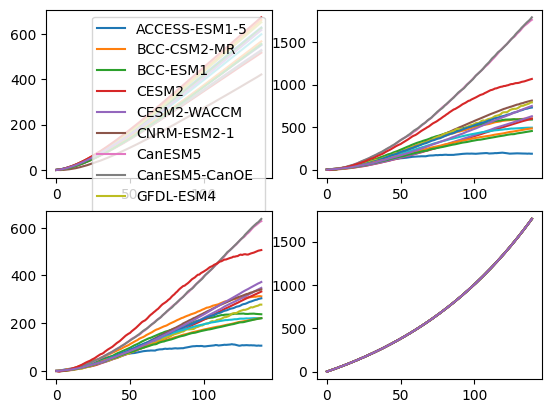

In [33]:
fig, axs = plt.subplots(2, 2)
axs=axs.flatten()

p1=axs[0].plot(ocn_ttl[:140,:])
axs[1].plot(glb_ttl[:140,:])

axs[2].plot(glb_dis[:140,:])
axs[3].plot(atm_ttl[:140,:])
axs[0].legend(p1,mdlfilt)

In [34]:
cumemis=atm_ttl+glb_ttl+ocn_ttl
cumemis_unfccc=atm_ttl+glb_ttl+ocn_ttl-glb_dis




In [35]:
pi_t=[]
tcre=[]
tcre_un=[]
for i,m in enumerate(mdlfilt):
        try:
         (tcretmp,pit)=get_tcre(cumemis[:70,i],tas[:70,i])
         (tcre_untmp,pit)=get_tcre(cumemis_unfccc[:70,i],tas[:70,i])
        except:
         tcretmp=np.NaN
         tcre_untmp=np.NaN
         pit=np.NaN
        pi_t.append(pit)
        tcre.append(tcretmp)
        tcre_un.append(tcre_untmp)


In [36]:
tcre=np.hstack(tcre)
tcre_un=np.hstack(tcre_un)


In [37]:
pit

287.0084442908116

1

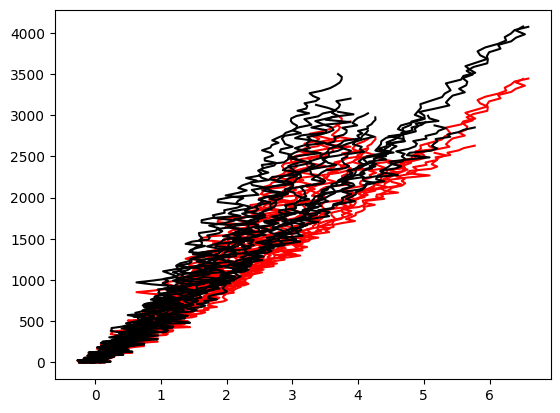

In [38]:
plt.plot(tas[:140,:]-pi_t,cumemis_unfccc[:140,:],'r')
plt.plot(tas[:140,:]-pi_t,cumemis[:140,:],'k')
1

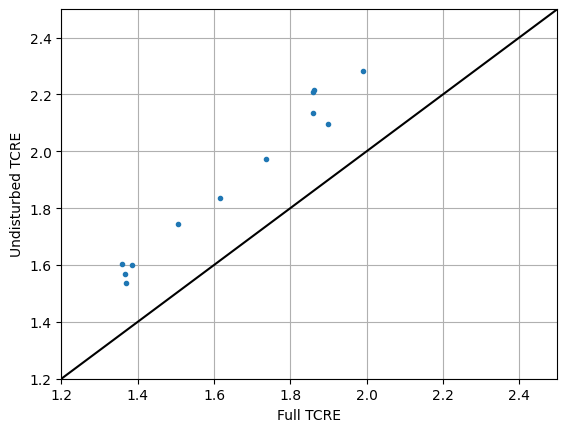

In [39]:
plt.plot(tcre,tcre_un,'.')
plt.plot([1.2,2.5],[1.2,2.5],'k-')

plt.xlim([1.2,2.5])
plt.ylim([1.2,2.5])
plt.xlabel('Full TCRE')
plt.ylabel('Undisturbed TCRE')
plt.grid()

!Scenarios


In [40]:
mdl26=['CESM2',  'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR']
oscns=['historical','ssp126','ssp245','ssp585']
scns=oscns

In [41]:
#READ concentrations

!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/future/CMIP6GHGConcentrationProjections_1_2_1/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc
!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/historical/CMIP6GHGConcentrationHistorical_1_2_0/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc
!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/future/CMIP6GHGConcentrationProjections_1_2_1/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc
!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/future/CMIP6GHGConcentrationProjections_1_2_1/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_2015-2500.nc

db26=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc')
dbhist=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc',decode_times=False)
db85=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc')
db45=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_2015-2500.nc')

dbconc=xr.concat((dbhist,db26),'time')
dbconc85=xr.concat((dbhist,db85),'time')
dbconc45=xr.concat((dbhist,db45),'time')




ppm26=dbconc['mole_fraction_of_carbon_dioxide_in_air'][1850:2350,1].values
ppm85=dbconc85['mole_fraction_of_carbon_dioxide_in_air'][1850:2350,1].values
ppm45=dbconc45['mole_fraction_of_carbon_dioxide_in_air'][1850:2350,1].values

atm_ttl=np.zeros([len(ppm26),len(mdl26),len(scns)])
atm_ttl[:,:,0]=np.repeat((ppm26-ppm26[0])[:,np.newaxis]*2.12,len(mdl26),axis=1)
atm_ttl[:,:,1]=np.repeat((ppm45-ppm45[0])[:,np.newaxis]*2.12,len(mdl26),axis=1)
atm_ttl[:,:,2]=np.repeat((ppm85-ppm45[0])[:,np.newaxis]*2.12,len(mdl26),axis=1)



File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc’ already there; not retrieving.

File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc’ already there; not retrieving.

File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc’ already there; not retrieving.

File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_2015-2500.nc’ already there; not retrieving.



In [42]:
readdata=0

In [43]:

ds={}
for s in oscns:
    print(s)
    if readdata:
        for i,m in enumerate(mdl26):
            print(i,len(mdl26),m)
            tmp=get_da(m,s)
            tmp.to_netcdf(datadir+'/'+m+'_'+s+'.nc')


historical
ssp126
ssp245
ssp585


In [44]:
ds={}
for s in oscns:
    ds[s]=[]
    for i,m in enumerate(mdl26):   
        ds[s].append(xr.open_dataset(datadir+'/'+m+'_'+s+'.nc'))


In [45]:
i=mdl26.index("GFDL-ESM4")
for s in oscns:
    ds[s][i]['cLand']=ds[s][i]['cSlVg']
    ds[s][i]['cLand_dist']=ds[s][i]['cSlVg_dist']
    

In [46]:
scns=['ssp126','ssp245','ssp585']


In [47]:
mdl26

['CESM2', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR']

In [48]:
i=mdl26.index("IPSL-CM6A-LR")
for s in scns:
    ds[s][i]['cLand'][0,:,:]=ds[s][i]['cLand'][1,:,:]
    ds[s][i]['cLand_dist'][0,:,:]=ds[s][i]['cLand_dist'][1,:,:]
    

In [49]:
dy_conc={}
for s in scns:
    print(s)
    dy_conc[s]=[]
    for i,m in enumerate(mdl26):
        print(m)
        dy_conc[s].append(xr.concat((ds['historical'][i],ds[s][i]),'year'))

ssp126
CESM2
GFDL-ESM4
IPSL-CM6A-LR
MPI-ESM1-2-LR
ssp245
CESM2
GFDL-ESM4
IPSL-CM6A-LR
MPI-ESM1-2-LR
ssp585
CESM2
GFDL-ESM4
IPSL-CM6A-LR
MPI-ESM1-2-LR


In [50]:
for s in scns:
    for i,m in enumerate(mdl26):
        tmp=dy_conc[s][i]
        dy_conc[s][i]['cOcn_d']=tmp['fgco2'].cumsum(dim='year')*3600*24*365
    

    

In [51]:
glb_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
glb_dis= np.ones((500,len(mdl26),len(scns)))*np.nan
ocn_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
#atm_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
prd_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
hrv_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
lit_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan

tas_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
for j,s in enumerate(scns):
    for i,m in enumerate(mdl26):
        co2atm=278*1.01**np.arange(0,len(dy_conc[s][i]['year']))
        (glb_ttl_tmp,glb_dis_tmp,ocn_ttl_tmp,atm_ttl_tmp,tas_tmp,prd_tmp,hrv_tmp,lit_tmp)=get_gflx(dy_conc[s][i],co2atm)
        glb_ttl[:len(glb_ttl_tmp),i,j]=glb_ttl_tmp
        glb_dis[:len(glb_ttl_tmp),i,j]=glb_dis_tmp
        ocn_ttl[:len(glb_ttl_tmp),i,j]=ocn_ttl_tmp
#        atm_ttl[:len(glb_ttl_tmp),i,j]=atm_ttl_tmp
        prd_ttl[:len(glb_ttl_tmp),i,j]=prd_tmp
        hrv_ttl[:len(glb_ttl_tmp),i,j]=hrv_tmp
        lit_ttl[:len(glb_ttl_tmp),i,j]=lit_tmp
        tas_ttl[:len(glb_ttl_tmp),i,j]=tas_tmp


In [52]:
i=mdl26.index("GFDL-ESM4")
glb_ttl[:,i,1:]=np.NaN
glb_dis[:,i,1:]=np.NaN


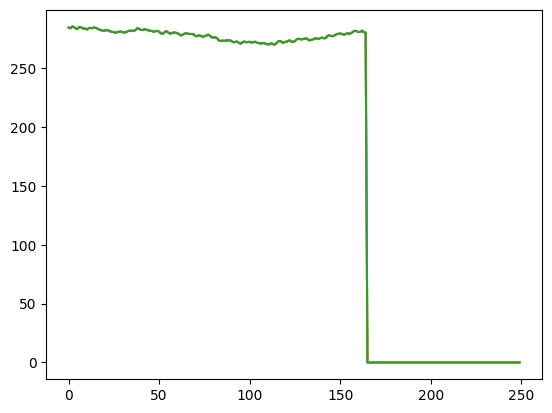

In [53]:
plt.plot(lit_ttl[:250,1,:])

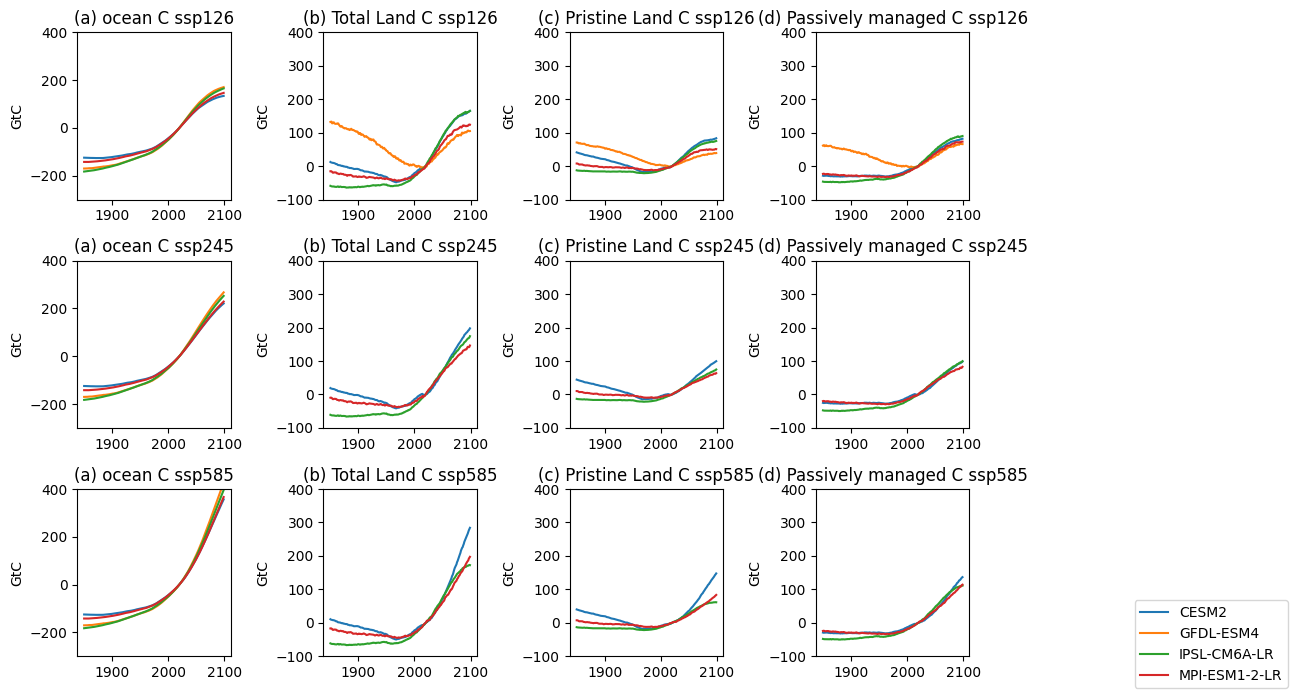

In [54]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7))
#axs=axs.flatten()
yrs=np.arange(1850,2100)
bsyr=np.where(yrs == 2020)[0][0]
for i,s in enumerate(scns):
    p1=axs[i,0].plot(yrs,ocn_ttl[:250,:,i]-ocn_ttl[bsyr,:,i])
    axs[i,0].set_title('(a) ocean C '+s)

    axs[i,0].set_ylabel('GtC')
    axs[i,0].set_ylim([-300,400])


    axs[i,1].plot(yrs,glb_ttl[:250,:,i]-glb_ttl[bsyr,:,i])
    axs[i,1].set_title('(b) Total Land C '+s)
    axs[i,1].set_ylabel('GtC')
    axs[i,1].set_ylim([-100,400])


    axs[i,2].plot(yrs,glb_dis[:250,:,i]-glb_dis[bsyr,:,i])
    axs[i,2].set_title('(c) Pristine Land C '+s)
    axs[i,2].set_ylabel('GtC')
    axs[i,2].set_ylim([-100,400])

    axs[i,3].plot(yrs,glb_ttl[:250,:,i]-glb_ttl[bsyr,:,i]-(glb_dis[:250,:,i]-glb_dis[bsyr,:,i]))
    axs[i,3].set_title('(d) Passively managed C '+s)
    axs[i,3].set_ylabel('GtC')
    axs[i,3].set_ylim([-100,400])
    #axs[3].plot(yrs,atm_ttl26[:250,:])
lg=fig.legend(p1,mdl26, bbox_to_anchor=(1.3, 0),loc = 'lower right')
plt.tight_layout()

In [56]:

cumemis=atm_ttl+glb_ttl+ocn_ttl
cumemis_unfccc=atm_ttl+glb_ttl+ocn_ttl-glb_dis

cumemis.shape

ValueError: operands could not be broadcast together with shapes (500,4,4) (500,4,3) 

In [ ]:
atm_ttl


In [ ]:
fig, axs = plt.subplots(3,3)
#axs=axs.flatten()

ext=[0,1000,2000]
for i,s in enumerate(scns):
    p1=axs[i,0].plot(np.arange(1850,2350),cumemis_unfccc[:,:,i]-cumemis_unfccc[170,:,i],'--')
    axs[i,0].set_xlim([2020,2100])
    axs[i,0].set_ylim([0,500+ext[i]])
    axs[i,0].set_title('CE (UNFCCC, '+s+')')
    axs[i,0].set_ylabel('PgC')

    axs[i,1].plot(np.arange(1850,2350),cumemis[:,:,i]-cumemis[170,:,i],'-')
    axs[i,1].set_xlim([2020,2100])
    axs[i,1].set_ylim([0,500+ext[i]])
    axs[i,1].set_title('CE (ESM, '+s+')')
    axs[i,1].set_ylabel('PgC')
    tmp=(cumemis[:,:,i]-cumemis_unfccc[:,:,i])
    axs[i,2].plot(np.arange(1850,2350),tmp-tmp[170,:],'-')
    axs[i,2].set_xlim([2020,2100])
    axs[i,2].set_ylim([-50,200])
    axs[i,2].set_title('CE (UNFCCC-ESM, '+s+')')
    axs[i,2].set_ylabel('PgC')



plt.tight_layout()


In [ ]:
fryr=ssp126.Emissions.emissions[:,0]

In [ ]:
tmp=ssp126.Emissions.emissions[86:335,1]
fos=np.zeros((len(tmp),len(scns)))
lu=np.zeros((len(tmp),len(scns)))

fos[:,0]=ssp126.Emissions.emissions[86:335,1]
lu[:,0]=ssp126.Emissions.emissions[86:335,2]
fos[:,1]=ssp245.Emissions.emissions[86:335,1]
lu[:,1]=ssp245.Emissions.emissions[86:335,2]
fos[:,2]=ssp585.Emissions.emissions[86:335,1]
lu[:,2]=ssp585.Emissions.emissions[86:335,2]

In [ ]:
fig, axs = plt.subplots(3,3)
#axs=axs.flatten()

#axs[0,0].plot(np.arange(1851,2100),lu26,'k--')
for i,s in enumerate(scns):
    p1=axs[i,0].plot(np.arange(1851,2100),np.diff(cumemis_unfccc[:250,:,i],axis=0)-np.tile(fos[:,i],(4,1)).T,'-',label=mdl26)
    axs[i,0].set_xlim([2000,2100])
    axs[i,0].set_ylim([-5,5])
    axs[i,0].set_title('(UNFCCC, '+s+')')
    axs[i,0].set_ylabel('PgC')
    axs[i,0].grid()
    #axs[0,0].legend()

    axs[i,1].plot(np.arange(1851,2100),np.diff(cumemis[:250,:,i],axis=0)-np.tile(fos[:,i],(4,1)).T,'-')
    axs[i,1].plot(np.arange(1851,2100),lu[:,i],'k--')
    axs[i,1].set_xlim([2000,2100])
    axs[i,1].set_ylim([-5,5])
    axs[i,1].set_title('(ESM, '+s+')')
    axs[i,1].set_ylabel('PgC')
    axs[i,1].grid()

    tmp=(cumemis_unfccc[:,:,i]-cumemis[:,:,i])
    axs[i,2].plot(np.arange(1851,2100),np.diff(tmp[:250,:],axis=0),'-')
    axs[i,2].set_xlim([2000,2100])
    axs[i,2].set_ylim([0-3,2])
    axs[i,2].set_title('Managed Land sink, '+s+'')
    axs[i,2].set_ylabel('PgC')
    axs[i,2].grid()

plt.tight_layout()
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0, 0.5))

In [ ]:
fig, axs = plt.subplots(2,2)
axs=axs.flatten()

#axs[0,0].plot(np.arange(1851,2100),lu26,'k--')
for i,s in enumerate(scns):
    p1=axs[i].plot(np.arange(1851,2100),np.diff(cumemis[:250,:,i]-fos[:250,i],axis=0),'-')
    axs[i].plot(np.arange(1851,2100),lu[:,i]+fos[:,i],'k--')
    axs[i].set_xlim([2000,2100])
    if i<3:
        axs[i].set_ylim([-5,5])
    else:
        axs[i].set_ylim([-5,5])
    axs[i].set_title('(Effective LU emissions, '+s+')')
    axs[i].set_ylabel('PgC')
    axs[i].grid()

axs[3].visible='off'
plt.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0, 0.5))

In [ ]:
f_in=[mdls.index(m) for m in mdl26]

In [ ]:
tcre[f_in]

In [ ]:
tcre_un[f_in]

In [ ]:
plt.plot(cumemis_unfccc[:250,:,0]/1000*tcre_un[f_in])
plt.plot(tas_ttl[:250,:,0]-tas_ttl[0,:,0],'--')


In [ ]:
plt.plot(cumemis[:250,:,0]/1000*tcre[f_in])
plt.plot(tas_ttl[:250,:,0]-tas_ttl[0,:,0],'--')


In [ ]:
plt.plot((cumemis_unfccc[:250,:,0]-cumemis_unfccc[bsyr,:,0])/1000*tcre_un[f_in],(cumemis[:250,:,0]-cumemis[bsyr,:,0])/1000*tcre[f_in])
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.grid()


In [ ]:
plt.plot((cumemis_unfccc[:250,:,1]-cumemis_unfccc[bsyr,:,1])/1000*tcre_un[f_in],(cumemis[:250,:,1]-cumemis[bsyr,:,1])/1000*tcre[f_in])
plt.plot([0,2],[0,2],'k--')
plt.xlim([0,2])
plt.ylim([0,2])

plt.grid()

In [ ]:
plt.plot((cumemis_unfccc[:250,:,2]-cumemis_unfccc[bsyr,:,2])/1000*tcre_un[f_in],(cumemis[:250,:,2]-cumemis[bsyr,:,2])/1000*tcre[f_in])
plt.plot([0,6],[0,6],'k--')
plt.xlim([0,6])
plt.ylim([0,6])

plt.grid()

In [ ]:
dy_conc['ssp126'][0]

In [ ]:
url = 'https://www.geoboundaries.org/data/1_3_3/zip/shapefile/NOR/NOR_ADM0.shp.zip'
norway_shapefile = gpd.read_file(url)

In [ ]:
def get_cgrids(ds,cnt):
  gdf = gpd.read_file('https://www.geoboundaries.org/data/1_3_3/zip/shapefile/'+cnt+'/'+cnt+'_ADM0.shp.zip')

  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  gdf_crs=gdf.translate(xoff=360)
  gdf["exists"] = 1

  out_grid=make_geocube(vector_data=gdf, measurements=["exists"], fill=np.nan, resolution=(0.05, -0.05)).fillna(0)

  out_grid=out_grid.rename({'x': 'lon','y': 'lat'})
    
  upsampled = out_grid.interp_like(ds)
  upsampled['intfrac']=upsampled['exists'].fillna(0)
  return upsampled


In [ ]:
da=dy_conc['ssp126'][0]
tmp=get_cgrids(da,'NOR')

In [ ]:
cland_nor=(dy_conc['ssp126'][0]['cLand']*tmp['exists']).mean('lat').mean('lon')
plt.plot(cland_nor['year'],cland_nor-cland_nor[bsyr])

cland_dis=(dy_conc['ssp126'][0]['cLand_dist']*tmp['exists']).mean('lat').mean('lon')
plt.plot(cland_nor['year'],cland_dis-cland_dis[bsyr])



In [ ]:
glb_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
glb_nordis= np.ones((500,len(mdl26),len(scns)))*np.nan
ocn_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
#atm_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
prd_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
hrv_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
lit_nor= np.ones((500,len(mdl26),len(scns)))*np.nan

tas_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
for j,s in enumerate(scns):
    for i,m in enumerate(mdl26):
        co2atm=278*1.01**np.arange(0,len(dy_conc[s][i]['year']))
        (glb_ttl_tmp,glb_dis_tmp,ocn_ttl_tmp,atm_ttl_tmp,tas_tmp,prd_tmp,hrv_tmp,lit_tmp)=get_gflx(dy_conc[s][i]*tmp,co2atm)
        glb_nor[:len(glb_ttl_tmp),i,j]=glb_ttl_tmp
        glb_nordis[:len(glb_ttl_tmp),i,j]=glb_dis_tmp
        ocn_nor[:len(glb_ttl_tmp),i,j]=ocn_ttl_tmp
#        atm_ttl[:len(glb_ttl_tmp),i,j]=atm_ttl_tmp
        prd_not[:len(glb_ttl_tmp),i,j]=prd_tmp
        hrv_nor[:len(glb_ttl_tmp),i,j]=hrv_tmp
        lit_nor[:len(glb_ttl_tmp),i,j]=lit_tmp
        tas_nor[:len(glb_ttl_tmp),i,j]=tas_tmp


In [ ]:
upsampled=make_weights(out_grid,out_fgrid,dy_conc['ssp126'][0])

(upsampled['distfrac']>0.5).plot()

In [ ]:
((upsampled['intfrac']>0.5)+3*(upsampled['distfrac']>0.5)).plot()